# Распознавание лиц с глубоким обучением

Обучим нейронную сеть распознаванию лиц. Будем использовать набор данных Labeled Faces in the Wild, содержащий более 13000 фотографий лиц известных людей (они собраны с Интернета). Оно встроенно в Scikit в качестве примера. Предназначен для изучения проблемы распознавания лиц. Эта база данных была создана исследователями из Массачусетского университета. Из 13 233 изображений 5 749 человек были обнаружены детектором лиц Виолы Джонс. 1 680 человек, изображенных на фотографиях, имеют две или более разных фотографий в наборе данных. Исходная база данных содержит четыре различных набора изображений LFW, а также три различных типа «выровненных» изображений.

Для нашей задачи импортируем пять наборов лиц, соответствующих пяти известным людям. Для каждого человека по 100 фотографий. Each facial image is labeled with the name of the person that the face belongs to.

**Д/з:** Конспектировать способ обнаружения лиц методом Виолы — Джонса с примерами


![](1_WxBM1lB5WzDjrDXYfi9gtw.gif)
 

In [1]:
import pandas as pd
from sklearn.datasets import fetch_lfw_people
# загрузка набора данных с функцией fetch_lfw_people
# параметр min_faces_per_person=100 указывает, что будем брать только фото тех людей, у которых есть минимум 100 фото
# параметр slice_=None означает, что не применяется никакого среза к изображениям на этом этапе (с исходным размером)
faces = fetch_lfw_people(min_faces_per_person=100, slice_=None)
# faces.images содержит изображения лиц в виде 3D массива (количество изображений, высота, ширина)
# : — берем все изображения, обрезаем каждое фото, оставляя центральную часть, чтобы сфокусироваться на лицах
faces.images = faces.images[:, 35:97, 39:86]
# умножая высоту на ширину узнаем общее количество пикселей в каждом изображении и преобразуем 3D на 2D
# каждое изображение представляется в виде одномерного вектора для дальнейшего анализа 
faces.data = faces.images.reshape(faces.images.shape[0], faces.images.shape[1] * faces.images.shape[2])
# сохраним общее количество изображений 
image_count = faces.images.shape[0]
image_height = faces.images.shape[1]
image_width = faces.images.shape[2]
# сколько различных лиц
class_count = len(faces.target_names)
# выводим их имена
print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 62, 47)


Всего было загружено 1140 изображений лиц. После обрезки каждая фотография имеет размер 47х62 пиксела. Выводим первые 24 фотографий:

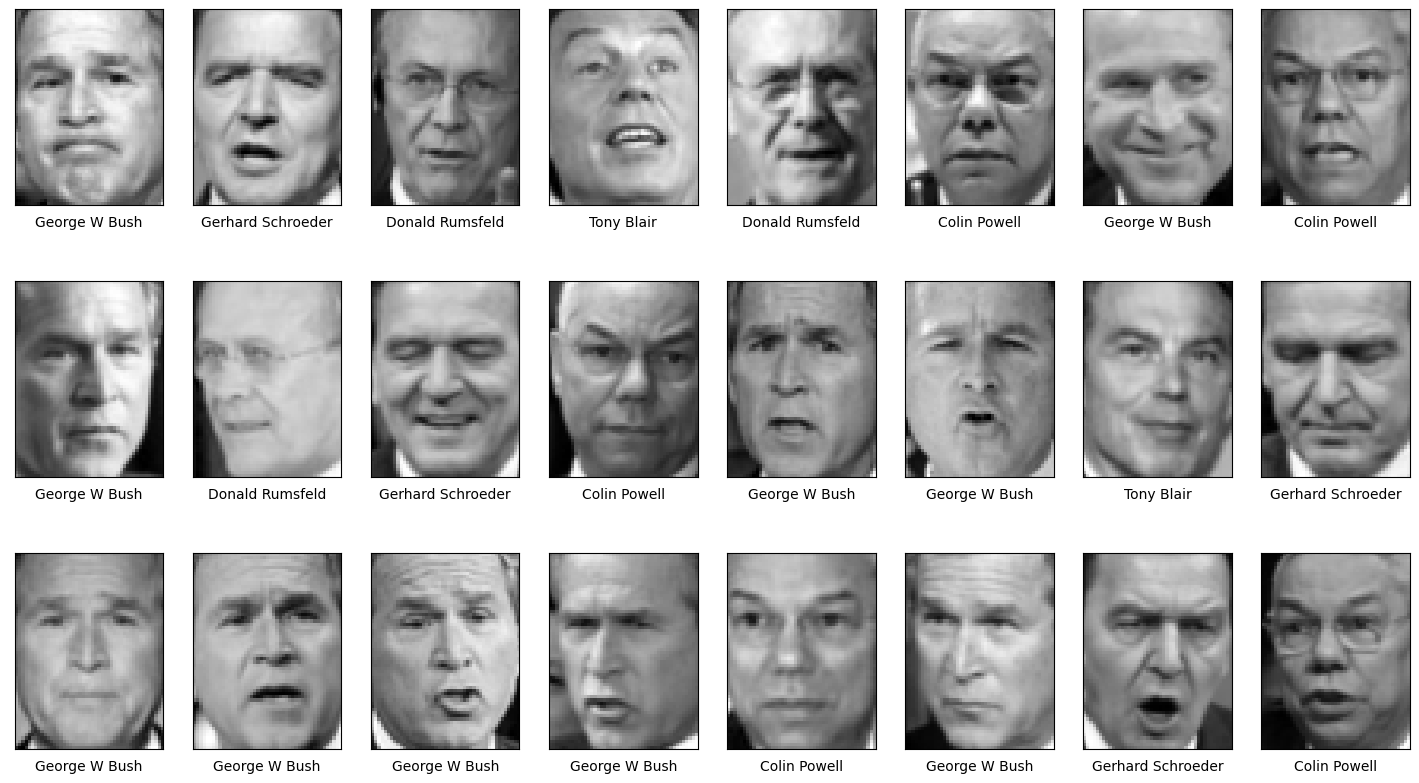

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 8, figsize=(18, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Cколько изображений для каждого человека:

<AxesSubplot:>

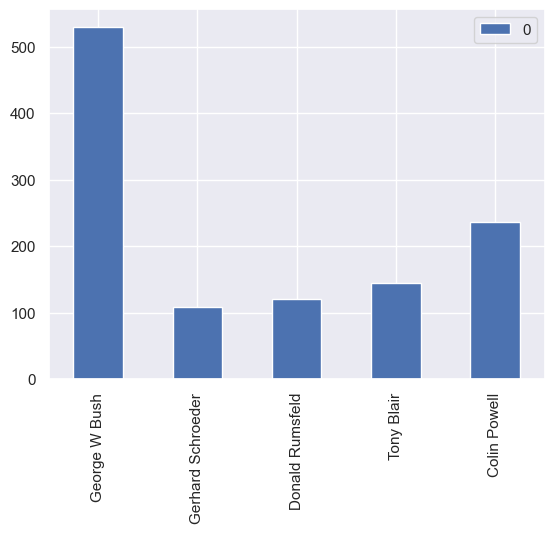

In [3]:
from collections import Counter
import seaborn as sns
sns.set()

counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

В наборе данных гораздо больше изображений Джорджа Буша-младшего. Классификационные модели лучше всего обучаются на сбалансированных наборах данных. Уменьшим набор данных до 100 изображений каждого человека:

In [4]:
import numpy as np

mask = np.zeros(faces.target.shape, dtype=bool)

# x_faces содержит 500 фотографий, а y_faces - соответствующие им метки 
# О для Калина Пауэлла, 1 для Дональда Рамсфельда и т. д.

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1
    
x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces.shape

(500, 2914)

Разделение данных на обучающие и тестовые:

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_faces, y_faces, train_size=0.8, stratify=y_faces, random_state=0)

## Создание и обучение нейросети
С использованием Keras создадим и обучим нейросеть состоящее из одного скрытого слоя с 512 нейронами. В качестве функции потерь используйте **sparse_categorical_crossentropy**, а в качестве функции активации на выходном слое - **softмax**, поскольку это задача мультиклассовой классификации

In [6]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
 
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1492480   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 1,495,045
Trainable params: 1,495,045
Non-trainable params: 0
_________________________________________________________________


Обучение нейросети

In [7]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=20)

Epoch 1/100
20/20 [==============================] - 1s 33ms/step - loss: 794.9645 - accuracy: 0.1825 - val_loss: 78.1750 - val_accuracy: 0.2500
Epoch 2/100
20/20 [==============================] - 0s 15ms/step - loss: 183.0715 - accuracy: 0.2400 - val_loss: 195.5671 - val_accuracy: 0.2700
Epoch 3/100
20/20 [==============================] - 0s 16ms/step - loss: 156.4520 - accuracy: 0.2800 - val_loss: 78.7068 - val_accuracy: 0.4600
Epoch 4/100
20/20 [==============================] - 0s 15ms/step - loss: 101.5776 - accuracy: 0.3175 - val_loss: 189.5751 - val_accuracy: 0.2700
Epoch 5/100
20/20 [==============================] - 0s 18ms/step - loss: 128.7108 - accuracy: 0.3225 - val_loss: 63.6080 - val_accuracy: 0.3800
Epoch 6/100
20/20 [==============================] - 0s 16ms/step - loss: 56.9415 - accuracy: 0.4600 - val_loss: 55.4649 - val_accuracy: 0.4900
Epoch 7/100
20/20 [==============================] - 0s 15ms/step - loss: 40.1876 - accuracy: 0.4675 - val_loss: 58.3151 - val_ac

Epoch 58/100
20/20 [==============================] - 0s 16ms/step - loss: 1.1203 - accuracy: 0.9250 - val_loss: 7.1837 - val_accuracy: 0.7100
Epoch 59/100
20/20 [==============================] - 0s 15ms/step - loss: 1.8104 - accuracy: 0.9075 - val_loss: 20.3047 - val_accuracy: 0.6200
Epoch 60/100
20/20 [==============================] - 0s 15ms/step - loss: 8.7858 - accuracy: 0.7500 - val_loss: 33.1217 - val_accuracy: 0.6400
Epoch 61/100
20/20 [==============================] - 0s 14ms/step - loss: 6.8004 - accuracy: 0.8100 - val_loss: 14.3768 - val_accuracy: 0.6500
Epoch 62/100
20/20 [==============================] - 0s 14ms/step - loss: 3.8855 - accuracy: 0.8425 - val_loss: 20.5194 - val_accuracy: 0.5600
Epoch 63/100
20/20 [==============================] - 0s 15ms/step - loss: 4.6756 - accuracy: 0.7750 - val_loss: 6.6118 - val_accuracy: 0.7500
Epoch 64/100
20/20 [==============================] - 0s 16ms/step - loss: 0.6526 - accuracy: 0.9425 - val_loss: 7.3219 - val_accuracy: 0.

Постройте графики точности обучения и валидации:

[]

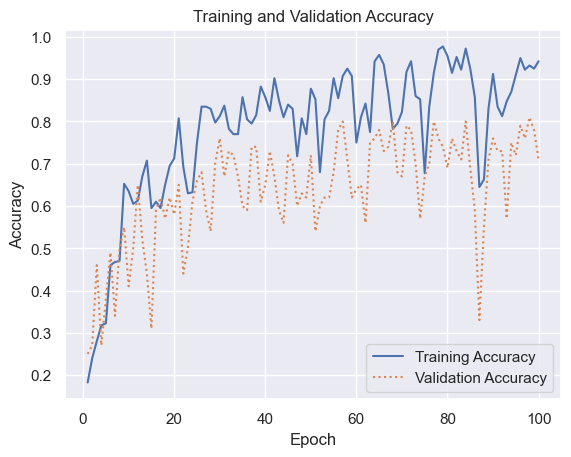

In [8]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Используя матрицу ошибок для визуализируем результаты работы сети на тестовых данных:

4/4 [==============================] - 0s 5ms/step


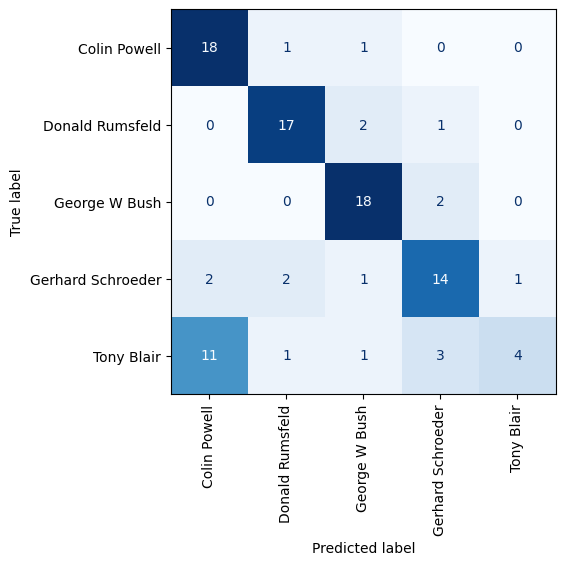

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd

sns.reset_orig()
y_pred = model.predict(x_test)
fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)

cmd.from_predictions(y_test, y_pred.argmax(axis=1),
                     display_labels=faces.target_names, colorbar=False,
                     cmap='Blues', xticks_rotation='vertical', ax=ax)

How many times did the model correctly identify George W. Bush? How many times did it identify him as someone else?

In [10]:
bush_index = np.where(faces.target_names == "George W Bush")[0][0]
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)
# Подсчет правильных предсказаний для Джорджа Буша
correct_bush_predictions = np.sum((y_pred_classes == bush_index) & (y_test == bush_index))
print(f"Количество правильных предсказаний для Джорджа Буша-младшего: {correct_bush_predictions}")

4/4 [==============================] - 0s 5ms/step
Количество правильных предсказаний для Джорджа Буша-младшего: 18


In [11]:
# Подсчет случаев, когда модель предсказала класс, отличный от bush_index
wrong_identifications = np.sum((y_pred_classes == bush_index) & (y_test != bush_index))
print(f"Количество раз, когда Джордж Буш был идентифицирован как другой человек: {wrong_identifications}")

Количество раз, когда Джордж Буш был идентифицирован как другой человек: 5
